# RST design for a DC-motor 
From HW3 2017 spring semester

## Plant model
  Zero-order-hold sampling of the DC-motor with transfer function
  $$ G(s) = \frac{1}{s(2s+1)} $$
  gives a discrete-time system with pulse transfer function 
  \begin{equation}
  G_d(z) = \frac{B(z)}{A(z)}= \frac{2\big(\frac{h}{2}-1+\mathrm{e}^{-\frac{h}{2}}\big)z + 2\big(1-\mathrm{e}^{-\frac{h}{2}}-\frac{h}{2}\mathrm{e}^{-\frac{h}{2}}\big)}{(z-1)\big(z-\mathrm{e}^{-\frac{h}{2}}\big)}.
  \end{equation}

In [1]:
import numpy as np
import sympy as sy
from sympy.utilities.codegen import codegen
import control.matlab as cm
import re
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
z = sy.symbols('z', real=False)
r1,s0,s1 = sy.symbols('r1,s0,s1', real=True)
hh = sy.symbols('h', real=True, positive=True)

Bp = 2*(0.5*hh - 1 + sy.exp(-0.5*hh))*z + 2*(1-sy.exp(-0.5*hh) - 0.5*hh*sy.exp(-0.5*hh))
Ap = (z-sy.exp(-0.5*hh))*(z-1)
print(Bp)
print(Ap)

-1.0*h*exp(-0.5*h) + z*(h + 2*exp(-0.5*h) - 2) - 2*exp(-0.5*h) + 2
(z - 1)*(z - exp(-0.5*h))


## Determine sampling period and desired closed loop poles
   In a continuous-time description of the desired closed-loop system we want the system to have two dominating poles at
   $$ -5 \pm i5. $$
   In addition to the two dominating poles, we want a third pole at
   $$ a=-20 $$
   to be able to control the response to disturbances. Determine a suitable sampling period $h$, and determine the poles (and characteristic polynomial) of the desired discrete-time closed-loop system.
   
### Solution
   Since we have dominating complex-conjugated poles, the sampling period should be such that
   $$ h\omega_n = 0.1 -- 0.6. $$
   Choose $$h = \frac{0.3}{\omega_n} = \frac{0.3}{\sqrt{5^2+5^2}} = \frac{0.3}{5\sqrt{2}} \approx 0.04. $$
   We get the discrete-time poles
   \begin{align*}
   p_{d_1} &= \exp{0.04(-5+i5)} = \exp(-0.2) \exp(i0.2) = 0.81\big(\cos(0.21) + i\sin(0.21)\big) \approx 0.80 + i0.16\\
   p_{d_2} &= p_{d_1}^* = 0.80 - i0.16\\
   p_{d_3} &= \exp(ah) = \exp(-20\cdot 0.04) = 0.45.
   \end{align*}


In [3]:
Ap = sy.simplify(Ap.subs(hh, 0.04))
Bp = sy.simplify(Bp.subs(hh, 0.04))
print(Bp)
print(Ap)

0.000397346613510541*z + 0.000394706454219282
(z - 1)*(z - 0.980198673306755)


## Design a 2-DoF controller
   Assume a structure of the controller as given in figure \ref{fig:2dof}. The controller is given by 
   $$ R(q)u = -S(q)y + T(q)u_c. $$
   With the plant-model
   $$ A(q)y = B(q)u$$
   we get the following difference equation for the closed-loop system
   $$ \big( A(q)R(q) + B(q)S(q) \big) y = B(q)T(q) u_c. $$
   Assume a suitable order (as low as possible) of the controller polynomials $R(q)$ and $S(q)$ and solve the diophantine equation 
   $$ A(q)R(q) + B(q)S(q)  = Ac(q) $$
   for $R$ and $S$. 

   Solve the equations for arbitrary $a$: Use a symbol $a$ in your calculations so that you can easily recalculate your controller for a different value of $a$. 

In [4]:
z = sy.symbols('z', real=False)
r1,s0,s1,aa = sy.symbols('r1,s0,s1,aa', real=True)

Ac = z**2 - z*(0.8*2) + (0.8**2 + 0.16**2)
Ao = z-aa
Acl = Ac*Ao

Rp = z+r1
Sp = s0*z + s1
RHS = sy.simplify(sy.expand(Acl))
diopheq =sy.poly(Ap*Rp+Bp*Sp-Acl, z)
dioph = diopheq.all_coeffs()
print(sy.latex(sy.poly(RHS, z)))
print(dioph)
print(Acl)
print(Ap*Rp)
print(Ac)
print(Ap*Rp)
print(sy.poly(sy.simplify(sy.expand(Ap*Rp + Bp*Sp)), z))

\operatorname{Poly}{\left( - 0.6656 aa + 1.0 z^{3} + z^{2} \left(- 1.0 aa - 1.6\right) + z \left(1.6 aa + 0.6656\right), z, domain=\mathbb{R}\left[aa\right] \right)}
[1.0*aa + 1.0*r1 + 0.000397346613510541*s0 - 0.380198673306755, -1.6*aa - 1.98019867330676*r1 + 0.000394706454219282*s0 + 0.000397346613510541*s1 + 0.314598673306755, 0.6656*aa + 0.980198673306755*r1 + 0.000394706454219282*s1]
(-aa + z)*(z**2 - 1.6*z + 0.6656)
(r1 + z)*(z - 1)*(z - 0.980198673306755)
z**2 - 1.6*z + 0.6656
(r1 + z)*(z - 1)*(z - 0.980198673306755)
Poly(1.0*z**3 + (1.0*r1 + 0.000397346613510541*s0 - 1.98019867330676)*z**2 + (-1.98019867330676*r1 + 0.000394706454219282*s0 + 0.000397346613510541*s1 + 0.980198673306755)*z + 0.980198673306755*r1 + 0.000394706454219282*s1, z, domain='RR[r1,s0,s1]')


In [5]:
sol = sy.solve(dioph, (r1,s0,s1))

In [6]:
print (-np.exp(-20*0.04) + 0.38)
print (- 0.98 + 0.6656)
print (1.6*np.exp(-20*0.04) - 0.98 + 0.6656)
print (-0.6656*np.exp(-20*0.04))


-0.0693289641172
-0.3144
0.404526342588
-0.299073358516


In [7]:
sol[r1].subs(aa, np.exp(-20*0.04))

-0.195457575341184

In [8]:
print('r_1 = %f' % sol[r1].subs(aa, np.exp(-20*0.04)))
print('s_0 = %f' % sol[s0].subs(aa, np.exp(-20*0.04)))
print('s_1 = %f' % sol[s1].subs(aa, np.exp(-20*0.04)))

t0 = Ac.evalf(subs={z:1})/Bp.evalf(subs={z:1,})
print('t_0 = %f' % t0)

R = Rp.subs(sol)
S = Sp.subs(sol)
T = t0*Ao

Hc = T*Bp/(Ac*Ao)
Hcc = t0*0.8/Ac
sy.pretty_print(sy.expand(Hc))
sy.pretty_print(sy.expand(Hcc))
sy.pretty_print(Hc.evalf(subs={z:1}))

sy.pretty_print(sy.simplify(Ap*R + Bp*S))

r_1 = -0.195458
s_0 = 317.927170
s_1 = -272.319090
t_0 = 82.822733
                                                                              
                    - -0.0329093326044447⋅aa⋅z                                
- ──────────────────────────────────────────────────────────────── - ─────────
        2                              3              2                    2  
  - aa⋅z  + 1.6⋅aa⋅z - - -0.6656⋅aa + z  - -1.6⋅(-1)⋅z  + 0.6656⋅z   - aa⋅z  +

                                                                              
          - -0.0326906673955553⋅aa                                            
─────────────────────────────────────────────────────── + ────────────────────
                            3              2                    2             
 1.6⋅aa⋅z - - -0.6656⋅aa + z  - -1.6⋅(-1)⋅z  + 0.6656⋅z   - aa⋅z  + 1.6⋅aa⋅z -

                     2                                                        
 0.0329093326044447⋅z                                         

In [9]:
0 + 2*1j

2j

In [10]:
sy.Poly((Ac*Ao).subs(aa, -0.2), z).all_coeffs()

[1.00000000000000, -1.40000000000000, 0.345600000000000, 0.133120000000000]

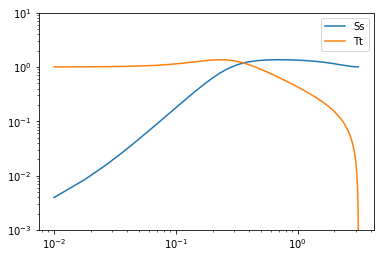

In [11]:
def my_bode(num, den, h=1.0):
    n = len(den)-1
    m = len(num)-1
    w = np.linspace(0.01, np.pi, 400);
    z = np.exp(1j*w);
    dd = den[-1]
    nd = num[-1]
    for i in range(n):
        dd += den[i]*np.power(z, n-i)
    for i in range(m):
        nd += num[i]*np.power(z, m-i)
    return nd/dd,w
def bodeplots(a, aa, Ap, R, Ac, Ao):
    numS = sy.list2numpy(sy.Poly((Ap*R).subs(aa, a), z).all_coeffs(), 
                        dtype=np.float64)
    numT = sy.list2numpy(sy.Poly((Bp*S).subs(aa, a), z).all_coeffs(), 
                        dtype=np.float64)
    den = sy.list2numpy(sy.Poly((Ac*Ao).subs(aa, a), z).all_coeffs(), 
                        dtype=np.float64)
    
    qS, wS = my_bode(numS, den)
    qT, wT = my_bode(numT, den)
    plt.figure()
    plt.loglog(wS, np.abs(qS))
    plt.loglog(wT, np.abs(qT))
    plt.ylim((0.001, 10))
    plt.legend(('Ss', 'Tt'))
    #cm.bode([Ss, Tt])
bodeplots(-0.009, aa, Ap, R, Ac, Ao)


In [12]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from functools import partial

In [13]:
interact(bodeplots, a=(0.0, 1.0), aa=fixed(aa), Ap=fixed(Ap), R=fixed(R), Ac=fixed(Ac),
        Ao=fixed(Ao))

interactive(children=(FloatSlider(value=0.5, description='a', max=1.0), Output()), _dom_classes=('widget-inter…

<function __main__.bodeplots(a, aa, Ap, R, Ac, Ao)>

In [ ]:
# Reorganize solution expression for matlab code generation
sol_expr = ('RST_DC_lab', [Bp.all_coeffs()[0], Bp.all_coeffs()[1],
                           Ap.all_coeffs()[1], Ap.all_coeffs()[2],
                           sol[r1], sol[s0], sol[s1], A2p.subs(z, 1)/Bp.subs(z,1), h,np.exp(h*po1) ])  

In [ ]:
# Export to matlab code
[(m_name, m_code)] = codegen(sol_expr, 'octave')

In [ ]:
m_code = m_code.replace("out1", "b0").replace("out2", "b1").replace("out3", "a1").replace("out4", "a2")
m_code = m_code.replace("out5", "r1").replace("out6", "s0").replace("out7", "s1").replace("out8", "t0")
m_code = m_code.replace("out9", "h").replace("out10", "obsPole")
m_code = m_code.replace("function ", "% function ")
m_code = m_code.replace("end", "")
print m_code
with open("/home/kjartan/Dropbox/undervisning/tec/MR2007/labs/dc_rst_design.m", "w") as text_file:
    text_file.write(m_code)

In [ ]:
cm.step?

In [ ]:

G = Km * cm.tf([1], [tau, 1, 0])
Gd = Km * cm.tf([tau*(hpt-1+np.exp(-hpt)), tau*(1-(1+hpt)*np.exp(-hpt))], [1, -(1+np.exp(-hpt)), np.exp(-hpt)], h)
Gd2 = cm.c2d(G, h)
print Gd
print Gd2

In [ ]:
print A2p
print A2p.evalf(subs={z:1})
print Bp
print Bp.evalf(subs={z:1})


In [ ]:
0.3/(5*np.sqrt(2))

In [ ]:
np.exp(-0.21)*np.sin(0.21)

In [ ]:
np.exp(0.03*(-14))

In [ ]:
 0.746*41.8
